# Use dataset <u>__7__</u> as test set

In [1]:
from inception_v4 import InceptionV4
from keras.applications.densenet import DenseNet201
from keras.layers import (GlobalAveragePooling2D, Dense, Conv2D, Flatten,
                          Dropout, concatenate, Input, Activation, normalization, GlobalAveragePooling1D, Conv1D)
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.models import Model, load_model, model_from_json, Input
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from utils import SaveModelOnMAE_tail, generate_generator, read_image_and_K_from_dir, read_48_points


%matplotlib inline
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
random.seed(7)
net = 'DenseNet201'
with_K = 'tail'
idx_test = [17, 13, 20, 21]


# Dataset
dir_path = './data/csv_files'
train_paths, train_labels, train_K, test_paths, test_labels, test_K = read_image_and_K_from_dir(dir_path, idx_test=idx_test)

test_paths_48, test_labels_48, test_K_48 = read_48_points(
    dir_path='./data/csv_files', dir_points='./data/48_points', idx_test=idx_test
)
test_paths_48, test_labels_48, test_K_48 = np.squeeze(test_paths_48).tolist(), np.squeeze(test_labels_48).tolist(), np.squeeze(test_K_48).tolist()

indexes_rand = list(range(len(train_K)))
random.shuffle(indexes_rand)
train_paths, train_labels, train_K = np.asarray(train_paths)[indexes_rand].tolist(), np.asarray(train_labels)[indexes_rand].tolist(), np.asarray(train_K)[indexes_rand].tolist()

idx_validate = np.loadtxt('./data/validation_selection_index.txt').astype(int)
validate_paths, validate_labels, validate_K = np.asarray(test_paths)[idx_validate].tolist(), np.asarray(test_labels)[idx_validate].tolist(), np.asarray(test_K)[idx_validate].tolist()

indexes_rand = list(range(len(test_K)))
random.shuffle(indexes_rand)
test_paths, test_labels, test_K = np.asarray(test_paths)[indexes_rand].tolist(), np.asarray(test_labels)[indexes_rand].tolist(), np.asarray(test_K)[indexes_rand].tolist()

print('\t\tpath\tlabel\tK')
print('train:\t\t{}\t{}\t{}'.format(len(train_paths), len(train_labels), len(train_K)))
print('val:\t\t{}\t{}\t{}'.format(len(validate_paths), len(validate_labels), len(validate_K)))
print('test:\t\t{}\t{}\t{}'.format(len(test_paths), len(test_labels), len(test_K)))
print('test_48:\t{}\t{}\t{}'.format(len(test_paths_48), len(test_labels_48), len(test_K_48)))

Using TensorFlow backend.


Reading 	train and validation set 	from subject 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 .csv
Reading 	test_48 set 			from subject 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 .csv
		path	label	K
train:		1047750	1047750	1047750
val:		500	500	500
test:		347700	347700	347700
test_48:	195	195	195


In [2]:
model = load_model('./acceptable_weights/weights_tail_K/DenseNet201_tail_K_MAE0.324.hdf5')

In [ ]:
# upgrade keras 2.1.5 -> 2.2.4
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
flat = GlobalAveragePooling2D()(base_model.output)
flat_len = 1
for i in range(1, len(flat.shape)):
    flat_len *= int(flat.shape[i])
K_len = min(flat_len // 1, 2048)
input_K = Input((K_len, 1))
# K_flow = Activation(activation='linear')(input_K)
K_flow = Conv1D(K_len//3, 3, activation='relu')(input_K)
K_flow = GlobalAveragePooling1D()(K_flow)
x = concatenate([flat, K_flow])
x = Dense(1024, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(1, activation='relu')(x)

model = Model(inputs=[*base_model.inputs, input_K], outputs=x, name=net)
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()

In [ ]:
batch_size_train = 4
epochs_per_iteration = 250000
batch_size_validate = len(validate_labels) // 4

save_dir_weights = './weights/weights_' + with_K + '_K/'
if not os.path.exists(save_dir_weights):
    os.mkdir(save_dir_weights)

checkpointer_best = ModelCheckpoint(
    filepath=save_dir_weights + net + '.hdf5',
    monitor='val_loss', verbose=1, save_best_only=True, mode='min'
)
saver_MAE = SaveModelOnMAE_tail()
print('Training ...')
train_generator = generate_generator(train_paths, train_labels, train_K, batch_size_train, net=net, with_K=with_K, K_len=K_len)
validate_generator = generate_generator(validate_paths, validate_labels, validate_K, batch_size_validate, net=net, with_K=with_K, K_len=K_len)
history = model.fit_generator(
    train_generator, steps_per_epoch = np.ceil(len(train_paths)/batch_size_train/epochs_per_iteration),
    epochs=epochs_per_iteration * 3,
    validation_data=validate_generator, validation_steps=2,
    verbose=1, callbacks=[checkpointer_best, saver_MAE]
)

Training ...
Epoch 1/750000
2/2 [==============================] - 32s 16s/step - loss: 1.6044 - val_loss: 0.4788

Epoch 00001: val_loss improved from inf to 0.47885, saving model to ./weights/weights_tail_K/DenseNet201.hdf5
Epoch 2/750000
2/2 [==============================] - 1s 428ms/step - loss: 0.9050 - val_loss: 0.4184

Epoch 00002: val_loss improved from 0.47885 to 0.41845, saving model to ./weights/weights_tail_K/DenseNet201.hdf5
Saving to weights\weights_tail_K\DenseNet201_tail_K_MAE0.418.hdf5
Epoch 3/750000
2/2 [==============================] - 1s 429ms/step - loss: 1.1691 - val_loss: 0.5711

Epoch 00003: val_loss did not improve from 0.41845
Epoch 4/750000
2/2 [==============================] - 1s 425ms/step - loss: 0.7750 - val_loss: 0.6201

Epoch 00004: val_loss did not improve from 0.41845
Epoch 5/750000
2/2 [==============================] - 1s 416ms/step - loss: 1.1870 - val_loss: 0.8547

Epoch 00005: val_loss did not improve from 0.41845
Epoch 6/750000
2/2 [==========

2/2 [==============================] - 1s 422ms/step - loss: 1.2792 - val_loss: 2.3763

Epoch 00049: val_loss did not improve from 0.34192
Epoch 50/750000
2/2 [==============================] - 1s 418ms/step - loss: 1.1708 - val_loss: 2.2362

Epoch 00050: val_loss did not improve from 0.34192
Epoch 51/750000
2/2 [==============================] - 1s 418ms/step - loss: 1.8659 - val_loss: 1.9533

Epoch 00051: val_loss did not improve from 0.34192
Epoch 52/750000
2/2 [==============================] - 1s 426ms/step - loss: 1.1963 - val_loss: 2.2293

Epoch 00052: val_loss did not improve from 0.34192
Epoch 53/750000
2/2 [==============================] - 1s 415ms/step - loss: 2.2160 - val_loss: 2.6841

Epoch 00053: val_loss did not improve from 0.34192
Epoch 54/750000
2/2 [==============================] - 1s 421ms/step - loss: 0.5308 - val_loss: 3.2787

Epoch 00054: val_loss did not improve from 0.34192
Epoch 55/750000
2/2 [==============================] - 1s 423ms/step - loss: 1.1435 - 

2/2 [==============================] - 1s 423ms/step - loss: 1.1983 - val_loss: 1.5274

Epoch 00102: val_loss did not improve from 0.34192
Epoch 103/750000
2/2 [==============================] - 1s 415ms/step - loss: 0.7150 - val_loss: 1.5725

Epoch 00103: val_loss did not improve from 0.34192
Epoch 104/750000
2/2 [==============================] - 1s 411ms/step - loss: 0.8446 - val_loss: 1.4748

Epoch 00104: val_loss did not improve from 0.34192
Epoch 105/750000
2/2 [==============================] - 1s 418ms/step - loss: 1.0527 - val_loss: 1.4257

Epoch 00105: val_loss did not improve from 0.34192
Epoch 106/750000
2/2 [==============================] - 1s 422ms/step - loss: 1.4664 - val_loss: 1.2207

Epoch 00106: val_loss did not improve from 0.34192
Epoch 107/750000
2/2 [==============================] - 1s 418ms/step - loss: 1.1329 - val_loss: 0.9413

Epoch 00107: val_loss did not improve from 0.34192
Epoch 108/750000
2/2 [==============================] - 1s 425ms/step - loss: 0.4

2/2 [==============================] - 1s 417ms/step - loss: 0.9740 - val_loss: 0.7347

Epoch 00149: val_loss did not improve from 0.34192
Epoch 150/750000
2/2 [==============================] - 1s 417ms/step - loss: 0.9311 - val_loss: 0.7069

Epoch 00150: val_loss did not improve from 0.34192
Epoch 151/750000
2/2 [==============================] - 1s 418ms/step - loss: 1.1178 - val_loss: 0.6794

Epoch 00151: val_loss did not improve from 0.34192
Epoch 152/750000
2/2 [==============================] - 1s 417ms/step - loss: 0.7744 - val_loss: 0.5677

Epoch 00152: val_loss did not improve from 0.34192
Epoch 153/750000
2/2 [==============================] - 1s 416ms/step - loss: 0.6604 - val_loss: 0.5044

Epoch 00153: val_loss did not improve from 0.34192
Epoch 154/750000
2/2 [==============================] - 1s 419ms/step - loss: 1.1977 - val_loss: 0.5343

Epoch 00154: val_loss did not improve from 0.34192
Epoch 155/750000
2/2 [==============================] - 1s 426ms/step - loss: 0.8


Epoch 00201: val_loss did not improve from 0.34192
Epoch 202/750000
2/2 [==============================] - 1s 424ms/step - loss: 1.3985 - val_loss: 1.0717

Epoch 00202: val_loss did not improve from 0.34192
Epoch 203/750000
2/2 [==============================] - 1s 419ms/step - loss: 0.9786 - val_loss: 1.3563

Epoch 00203: val_loss did not improve from 0.34192
Epoch 204/750000
2/2 [==============================] - 1s 417ms/step - loss: 1.5422 - val_loss: 1.6057

Epoch 00204: val_loss did not improve from 0.34192
Epoch 205/750000
2/2 [==============================] - 1s 422ms/step - loss: 1.1481 - val_loss: 1.7698

Epoch 00205: val_loss did not improve from 0.34192
Epoch 206/750000
2/2 [==============================] - 1s 423ms/step - loss: 0.9670 - val_loss: 1.6351

Epoch 00206: val_loss did not improve from 0.34192
Epoch 207/750000
2/2 [==============================] - 1s 418ms/step - loss: 0.8739 - val_loss: 1.4714

Epoch 00207: val_loss did not improve from 0.34192
Epoch 208/75

2/2 [==============================] - 1s 421ms/step - loss: 1.1872 - val_loss: 0.4426

Epoch 00254: val_loss did not improve from 0.34192
Saving to weights\weights_tail_K\DenseNet201_tail_K_MAE0.443.hdf5
Epoch 255/750000
2/2 [==============================] - 1s 431ms/step - loss: 1.2885 - val_loss: 0.3820

Epoch 00255: val_loss did not improve from 0.34192
Saving to weights\weights_tail_K\DenseNet201_tail_K_MAE0.382.hdf5
Epoch 256/750000
2/2 [==============================] - 1s 437ms/step - loss: 0.8919 - val_loss: 0.3746

Epoch 00256: val_loss did not improve from 0.34192
Saving to weights\weights_tail_K\DenseNet201_tail_K_MAE0.375.hdf5
Epoch 257/750000
2/2 [==============================] - 1s 420ms/step - loss: 1.0334 - val_loss: 0.3669

Epoch 00257: val_loss did not improve from 0.34192
Saving to weights\weights_tail_K\DenseNet201_tail_K_MAE0.367.hdf5
Epoch 258/750000
2/2 [==============================] - 1s 422ms/step - loss: 1.3298 - val_loss: 0.4271

Epoch 00258: val_loss di

2/2 [==============================] - 1s 415ms/step - loss: 1.2537 - val_loss: 2.0112

Epoch 00302: val_loss did not improve from 0.34192
Epoch 303/750000
2/2 [==============================] - 1s 425ms/step - loss: 0.7476 - val_loss: 2.1407

Epoch 00303: val_loss did not improve from 0.34192
Epoch 304/750000
2/2 [==============================] - 1s 430ms/step - loss: 0.9751 - val_loss: 2.1862

Epoch 00304: val_loss did not improve from 0.34192
Epoch 305/750000
2/2 [==============================] - 1s 422ms/step - loss: 1.1263 - val_loss: 2.1608

Epoch 00305: val_loss did not improve from 0.34192
Epoch 306/750000
2/2 [==============================] - 1s 425ms/step - loss: 1.1255 - val_loss: 2.0894

Epoch 00306: val_loss did not improve from 0.34192
Epoch 307/750000
2/2 [==============================] - 1s 415ms/step - loss: 0.7220 - val_loss: 1.9143

Epoch 00307: val_loss did not improve from 0.34192
Epoch 308/750000
2/2 [==============================] - 1s 418ms/step - loss: 0.8

2/2 [==============================] - 1s 417ms/step - loss: 1.3366 - val_loss: 0.6985

Epoch 00354: val_loss did not improve from 0.34192
Epoch 355/750000
2/2 [==============================] - 1s 414ms/step - loss: 0.7143 - val_loss: 0.6802

Epoch 00355: val_loss did not improve from 0.34192
Epoch 356/750000
2/2 [==============================] - 1s 417ms/step - loss: 0.5740 - val_loss: 0.6892

Epoch 00356: val_loss did not improve from 0.34192
Epoch 357/750000
2/2 [==============================] - 1s 412ms/step - loss: 1.1672 - val_loss: 0.6742

Epoch 00357: val_loss did not improve from 0.34192
Epoch 358/750000
2/2 [==============================] - 1s 419ms/step - loss: 0.7326 - val_loss: 0.6812

Epoch 00358: val_loss did not improve from 0.34192
Epoch 359/750000
2/2 [==============================] - 1s 416ms/step - loss: 1.2866 - val_loss: 0.6545

Epoch 00359: val_loss did not improve from 0.34192
Epoch 360/750000
2/2 [==============================] - 1s 420ms/step - loss: 0.9

2/2 [==============================] - 1s 414ms/step - loss: 0.9960 - val_loss: 0.8580

Epoch 00405: val_loss did not improve from 0.34192
Epoch 406/750000
2/2 [==============================] - 1s 417ms/step - loss: 1.7567 - val_loss: 1.0714

Epoch 00406: val_loss did not improve from 0.34192
Epoch 407/750000
2/2 [==============================] - 1s 424ms/step - loss: 1.0211 - val_loss: 1.2942

Epoch 00407: val_loss did not improve from 0.34192
Epoch 408/750000
2/2 [==============================] - 1s 413ms/step - loss: 1.1754 - val_loss: 1.5373

Epoch 00408: val_loss did not improve from 0.34192
Epoch 409/750000
2/2 [==============================] - 1s 423ms/step - loss: 0.5825 - val_loss: 1.7266

Epoch 00409: val_loss did not improve from 0.34192
Epoch 410/750000
2/2 [==============================] - 1s 413ms/step - loss: 0.9908 - val_loss: 1.7471

Epoch 00410: val_loss did not improve from 0.34192
Epoch 411/750000
2/2 [==============================] - 1s 420ms/step - loss: 0.9


Epoch 00457: val_loss did not improve from 0.34192
Epoch 458/750000
2/2 [==============================] - 1s 428ms/step - loss: 0.9252 - val_loss: 1.2989

Epoch 00458: val_loss did not improve from 0.34192
Epoch 459/750000
2/2 [==============================] - 1s 417ms/step - loss: 1.4388 - val_loss: 1.4837

Epoch 00459: val_loss did not improve from 0.34192
Epoch 460/750000
2/2 [==============================] - 1s 419ms/step - loss: 1.6533 - val_loss: 1.4242

Epoch 00460: val_loss did not improve from 0.34192
Epoch 461/750000
2/2 [==============================] - 1s 411ms/step - loss: 0.9560 - val_loss: 1.3466

Epoch 00461: val_loss did not improve from 0.34192
Epoch 462/750000
2/2 [==============================] - 1s 416ms/step - loss: 0.7203 - val_loss: 1.1578

Epoch 00462: val_loss did not improve from 0.34192
Epoch 463/750000
2/2 [==============================] - 1s 429ms/step - loss: 0.7144 - val_loss: 1.1518

Epoch 00463: val_loss did not improve from 0.34192
Epoch 464/75

2/2 [==============================] - 1s 426ms/step - loss: 1.3056 - val_loss: 0.4190

Epoch 00509: val_loss did not improve from 0.34192
Saving to weights\weights_tail_K\DenseNet201_tail_K_MAE0.419.hdf5
Epoch 510/750000
2/2 [==============================] - 1s 437ms/step - loss: 0.9993 - val_loss: 0.3290

Epoch 00510: val_loss improved from 0.34192 to 0.32902, saving model to ./weights/weights_tail_K/DenseNet201.hdf5
Saving to weights\weights_tail_K\DenseNet201_tail_K_MAE0.329.hdf5
Epoch 511/750000
2/2 [==============================] - 1s 426ms/step - loss: 0.8698 - val_loss: 0.3501

Epoch 00511: val_loss did not improve from 0.32902
Saving to weights\weights_tail_K\DenseNet201_tail_K_MAE0.35.hdf5
Epoch 512/750000
2/2 [==============================] - 1s 442ms/step - loss: 1.2666 - val_loss: 0.3549

Epoch 00512: val_loss did not improve from 0.32902
Saving to weights\weights_tail_K\DenseNet201_tail_K_MAE0.355.hdf5
Epoch 513/750000
2/2 [==============================] - 1s 430ms/st

2/2 [==============================] - 1s 413ms/step - loss: 1.1662 - val_loss: 0.7225

Epoch 00556: val_loss did not improve from 0.32902
Epoch 557/750000
2/2 [==============================] - 1s 427ms/step - loss: 0.9885 - val_loss: 0.6851

Epoch 00557: val_loss did not improve from 0.32902
Epoch 558/750000
2/2 [==============================] - 1s 418ms/step - loss: 1.8830 - val_loss: 0.5901

Epoch 00558: val_loss did not improve from 0.32902
Epoch 559/750000
2/2 [==============================] - 1s 419ms/step - loss: 0.6877 - val_loss: 0.5080

Epoch 00559: val_loss did not improve from 0.32902
Epoch 560/750000
2/2 [==============================] - 1s 434ms/step - loss: 0.8593 - val_loss: 0.5236

Epoch 00560: val_loss did not improve from 0.32902
Epoch 561/750000
2/2 [==============================] - 1s 419ms/step - loss: 1.1243 - val_loss: 0.4630

Epoch 00561: val_loss did not improve from 0.32902
Epoch 562/750000
2/2 [==============================] - 1s 413ms/step - loss: 0.9

2/2 [==============================] - 1s 435ms/step - loss: 0.7743 - val_loss: 0.8764

Epoch 00603: val_loss did not improve from 0.32902
Epoch 604/750000
2/2 [==============================] - 1s 429ms/step - loss: 1.0587 - val_loss: 0.8093

Epoch 00604: val_loss did not improve from 0.32902
Epoch 605/750000
2/2 [==============================] - 1s 429ms/step - loss: 0.9547 - val_loss: 0.7299

Epoch 00605: val_loss did not improve from 0.32902
Epoch 606/750000
2/2 [==============================] - 1s 412ms/step - loss: 0.6665 - val_loss: 0.7144

Epoch 00606: val_loss did not improve from 0.32902
Epoch 607/750000
2/2 [==============================] - 1s 422ms/step - loss: 0.5894 - val_loss: 0.5961

Epoch 00607: val_loss did not improve from 0.32902
Epoch 608/750000
2/2 [==============================] - 1s 416ms/step - loss: 1.1899 - val_loss: 0.5786

Epoch 00608: val_loss did not improve from 0.32902
Epoch 609/750000
2/2 [==============================] - 1s 420ms/step - loss: 1.5


Epoch 00655: val_loss did not improve from 0.32902
Epoch 656/750000
2/2 [==============================] - 1s 433ms/step - loss: 0.9308 - val_loss: 0.6314

Epoch 00656: val_loss did not improve from 0.32902
Epoch 657/750000
2/2 [==============================] - 1s 422ms/step - loss: 0.6463 - val_loss: 0.5119

Epoch 00657: val_loss did not improve from 0.32902
Epoch 658/750000
2/2 [==============================] - 1s 429ms/step - loss: 0.7815 - val_loss: 0.4156

Epoch 00658: val_loss did not improve from 0.32902
Saving to weights\weights_tail_K\DenseNet201_tail_K_MAE0.416.hdf5
Epoch 659/750000
2/2 [==============================] - 1s 427ms/step - loss: 0.6928 - val_loss: 0.3085

Epoch 00659: val_loss improved from 0.32902 to 0.30850, saving model to ./weights/weights_tail_K/DenseNet201.hdf5
Saving to weights\weights_tail_K\DenseNet201_tail_K_MAE0.308.hdf5
Epoch 660/750000
2/2 [==============================] - 1s 423ms/step - loss: 1.0852 - val_loss: 0.3031

Epoch 00660: val_loss im


Epoch 00700: val_loss did not improve from 0.30305
Epoch 701/750000
2/2 [==============================] - 1s 420ms/step - loss: 0.8963 - val_loss: 1.8971

Epoch 00701: val_loss did not improve from 0.30305
Epoch 702/750000
2/2 [==============================] - 1s 415ms/step - loss: 0.9817 - val_loss: 1.7968

Epoch 00702: val_loss did not improve from 0.30305
Epoch 703/750000
2/2 [==============================] - 1s 412ms/step - loss: 1.2757 - val_loss: 1.8091

Epoch 00703: val_loss did not improve from 0.30305
Epoch 704/750000
2/2 [==============================] - 1s 415ms/step - loss: 0.6863 - val_loss: 1.6579

Epoch 00704: val_loss did not improve from 0.30305
Epoch 705/750000
2/2 [==============================] - 1s 415ms/step - loss: 1.1845 - val_loss: 1.4610

Epoch 00705: val_loss did not improve from 0.30305
Epoch 706/750000
2/2 [==============================] - 1s 417ms/step - loss: 1.3663 - val_loss: 1.1712

Epoch 00706: val_loss did not improve from 0.30305
Epoch 707/75

2/2 [==============================] - 1s 414ms/step - loss: 1.1234 - val_loss: 0.5072

Epoch 00749: val_loss did not improve from 0.30305
Epoch 750/750000
2/2 [==============================] - 1s 417ms/step - loss: 1.1088 - val_loss: 0.5408

Epoch 00750: val_loss did not improve from 0.30305
Epoch 751/750000
2/2 [==============================] - 1s 415ms/step - loss: 0.9230 - val_loss: 0.5260

Epoch 00751: val_loss did not improve from 0.30305
Epoch 752/750000
2/2 [==============================] - 1s 420ms/step - loss: 1.5400 - val_loss: 0.5087

Epoch 00752: val_loss did not improve from 0.30305
Epoch 753/750000
2/2 [==============================] - 1s 422ms/step - loss: 0.6962 - val_loss: 0.4961

Epoch 00753: val_loss did not improve from 0.30305
Epoch 754/750000
2/2 [==============================] - 1s 415ms/step - loss: 0.9626 - val_loss: 0.4972

Epoch 00754: val_loss did not improve from 0.30305
Epoch 755/750000
2/2 [==============================] - 1s 419ms/step - loss: 0.9


Epoch 00801: val_loss did not improve from 0.30305
Epoch 802/750000
2/2 [==============================] - 1s 422ms/step - loss: 1.2147 - val_loss: 0.7919

Epoch 00802: val_loss did not improve from 0.30305
Epoch 803/750000
2/2 [==============================] - 1s 422ms/step - loss: 0.4517 - val_loss: 0.8025

Epoch 00803: val_loss did not improve from 0.30305
Epoch 804/750000
2/2 [==============================] - 1s 430ms/step - loss: 0.4550 - val_loss: 0.7638

Epoch 00804: val_loss did not improve from 0.30305
Epoch 805/750000
2/2 [==============================] - 1s 417ms/step - loss: 0.7097 - val_loss: 0.7481

Epoch 00805: val_loss did not improve from 0.30305
Epoch 806/750000
2/2 [==============================] - 1s 429ms/step - loss: 1.2929 - val_loss: 0.7094

Epoch 00806: val_loss did not improve from 0.30305
Epoch 807/750000
2/2 [==============================] - 1s 427ms/step - loss: 1.3226 - val_loss: 0.7087

Epoch 00807: val_loss did not improve from 0.30305
Epoch 808/75

2/2 [==============================] - 1s 420ms/step - loss: 0.9661 - val_loss: 1.2239

Epoch 00854: val_loss did not improve from 0.30305
Epoch 855/750000
2/2 [==============================] - 1s 420ms/step - loss: 1.0736 - val_loss: 1.0460

Epoch 00855: val_loss did not improve from 0.30305
Epoch 856/750000
2/2 [==============================] - 1s 421ms/step - loss: 1.1854 - val_loss: 0.9046

Epoch 00856: val_loss did not improve from 0.30305
Epoch 857/750000
2/2 [==============================] - 1s 422ms/step - loss: 1.1084 - val_loss: 0.8745

Epoch 00857: val_loss did not improve from 0.30305
Epoch 858/750000
2/2 [==============================] - 1s 420ms/step - loss: 0.7100 - val_loss: 0.8763

Epoch 00858: val_loss did not improve from 0.30305
Epoch 859/750000
2/2 [==============================] - 1s 415ms/step - loss: 1.4650 - val_loss: 0.9809

Epoch 00859: val_loss did not improve from 0.30305
Epoch 860/750000
2/2 [==============================] - 1s 429ms/step - loss: 1.1


Epoch 00906: val_loss did not improve from 0.30305
Epoch 907/750000
2/2 [==============================] - 1s 429ms/step - loss: 0.9642 - val_loss: 1.3718

Epoch 00907: val_loss did not improve from 0.30305
Epoch 908/750000
2/2 [==============================] - 1s 421ms/step - loss: 1.5369 - val_loss: 1.2896

Epoch 00908: val_loss did not improve from 0.30305
Epoch 909/750000
2/2 [==============================] - 1s 422ms/step - loss: 1.6273 - val_loss: 1.0482

Epoch 00909: val_loss did not improve from 0.30305
Epoch 910/750000
2/2 [==============================] - 1s 430ms/step - loss: 0.8419 - val_loss: 0.9105

Epoch 00910: val_loss did not improve from 0.30305
Epoch 911/750000
1/2 [==============>...............] - ETA: 0s - loss: 0.6563

In [ ]:
vl, l = history.history['val_loss'], history.history['loss']
vl, l = np.asarray(vl), np.asarray(l)
vl[vl > 1], l[l > 1] = 1, 1

plt.plot(vl, 'r')
plt.plot(l, 'b')
plt.legend(['val_loss', 'loss'])
plt.show()

Loading 1/7 model: ./weights/weights_tail_K/DenseNet201_tail_K_MAE0.303.hdf5
(195,)


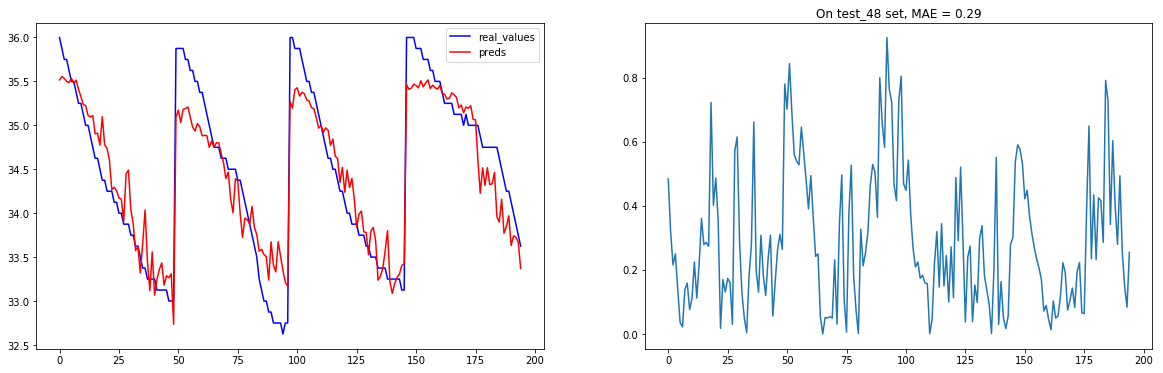

In [6]:
# test
K_len = 1920
losses = [0.303, 0.308, 0.311, 0.313, 0.326, 0.329, 0.335]
for idx, loss in enumerate(losses[:1]):
    print('Loading {}/{} model: {}'.format(idx+1, len(losses), './weights/weights_tail_K/DenseNet201_tail_K_MAE'+str(loss)+'.hdf5'))
    model = load_model('./weights/weights_tail_K/DenseNet201_tail_K_MAE'+str(loss)+'.hdf5')
    generator_for_test = generate_generator(test_paths_48, test_labels_48, test_K_48, len(test_labels_48), net=net, with_K=with_K, K_len=K_len)
    X_test, Y_test = generator_for_test.__next__()
    preds = np.squeeze(model.predict(X_test))
    fg, (ax0, ax1) = plt.subplots(1, 2, figsize=(20, 6))
    ax0.plot(Y_test, 'b')
    ax0.plot(preds, 'r')
    ax0.legend(['real_values', 'preds'])
    ax1.plot(np.abs(preds - Y_test))
    MAE = round(np.mean(abs(preds - Y_test)), 3)
    ax1.set_title('On test_48 set, MAE = {}'.format(MAE))
    print(np.unique(preds).shape)
    plt.show()

In [7]:
import pandas as pd
label_pred = np.hstack([np.asarray(range(Y_test.shape[0])).reshape(-1, 1), Y_test.reshape(-1, 1), preds.reshape(-1, 1)])
label_pred = pd.DataFrame(label_pred)
label_pred.to_csv(
    os.path.join('preds', 'preds_' + with_K + '_K', '_'.join([net, with_K, 'K_MAE', str(MAE) + '.txt'])),
    index=None,
    header=['index', 'label', 'prediction']
)